In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import math  
import numpy as np
import pandas as pd

# SIR model

In [2]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [3]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [4]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))

S, I, R = ret.T


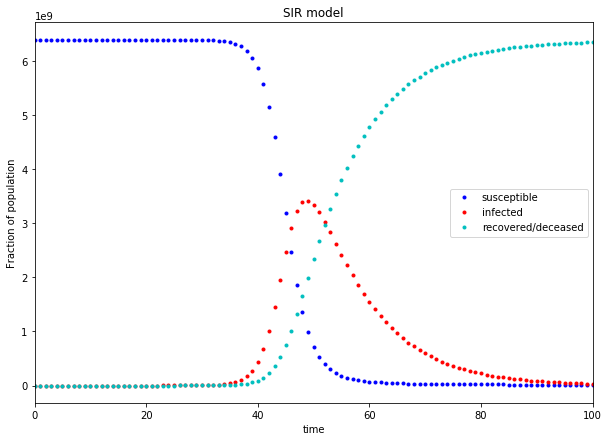

In [5]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [7]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])


In [8]:
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [9]:
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [10]:
df['Date'] =pd.to_datetime(df.Date)


In [11]:
df = df[df['Country/Region'] != 'China']
df_c = df
df.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [12]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()

In [13]:
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [14]:
train = 0.85
index = math.ceil(train * len(df['Confirmed'].values))
index

58

In [15]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [16]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = 6.4 *(10**9)
I0, R0 = y[0], 0
S0 = N - I0 - R0

In [17]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [18]:
def opt_ode(x, beta, gamma):
    return odeint(deriv, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err(params, x):
    beta, gamma = params
    ret = odeint(deriv, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [19]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.23079686946277314
 hess_inv: array([[0.04040171, 0.03957957],
       [0.03957957, 0.03883613]])
      jac: array([ 0.00176579, -0.00048365])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 275
      nit: 3
     njev: 66
   status: 2
  success: False
        x: array([2.90420271, 2.73198681])


In [20]:
# pcov

In [21]:
# fitted = opt_ode(x, *popt)
fitted = opt_ode(x, *beta_hat)

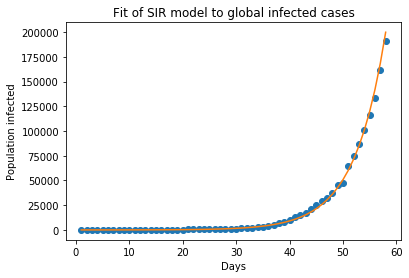

Optimal parameters: beta = 2.903577096696116  and gamma =  2.7318836758453617


In [22]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [23]:
# beta, gamma = popt[0], popt[1]
beta, gamma = beta_hat[0], beta_hat[1]

In [24]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [25]:
y0 = S0, I0, R0
ret = odeint(deriv, y0, X, args=(N, beta, gamma))

S, I, R = ret.T


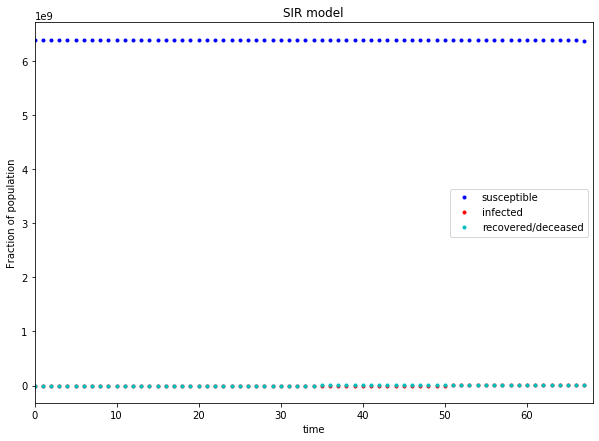

In [26]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(X))
plt.show()

In [27]:
y0 = S0, I0, R0
ret = odeint(deriv, y0, [i for i in range(150)], args=(N, beta, gamma))

S, I, R = ret.T

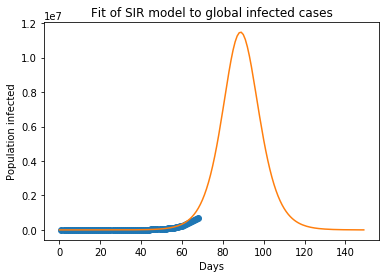

In [28]:
plt.plot(X, Y, 'o')
plt.plot([i for i in range(150)], I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

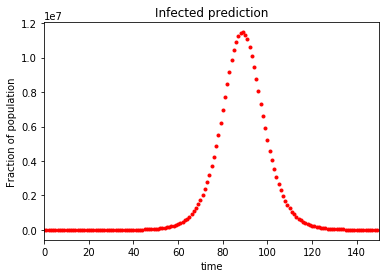

In [29]:
plt.plot(I, 'r.', label='infected');
plt.title("Infected prediction")
plt.xlabel("time");
plt.ylabel("Fraction of population");
plt.xlim(0,150)
plt.show()

In [30]:
max(I)

11473551.085044645

In [31]:
max(df['Confirmed'].values)

700167

In [34]:
lim = len(Y)
# mse = mean_squared_error(y, I[:lim])
rmsle = math.sqrt(mean_squared_log_error(Y[index:], I[index:lim]))
print(rmsle)

0.24186827426457497


# Analysing each country individualy

In [35]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [36]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [37]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [38]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [39]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [40]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [347]:
country = 'Kenya'

In [348]:
temp = df_c[df_c['Country/Region'] == country].reset_index()
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
50,8988,Kenya,-0.0236,37.9062,2020-03-13,1
51,9166,Kenya,-0.0236,37.9062,2020-03-14,1
52,9344,Kenya,-0.0236,37.9062,2020-03-15,3
53,9522,Kenya,-0.0236,37.9062,2020-03-16,3
54,9700,Kenya,-0.0236,37.9062,2020-03-17,3


In [349]:
N = int(pop[pop['Country/Region'] == country]['Population'])
N

53771296

In [350]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
63,11302,Kenya,-0.0236,37.9062,2020-03-26,31,14
64,11480,Kenya,-0.0236,37.9062,2020-03-27,31,15
65,11658,Kenya,-0.0236,37.9062,2020-03-28,38,16
66,11836,Kenya,-0.0236,37.9062,2020-03-29,42,17
67,12014,Kenya,-0.0236,37.9062,2020-03-30,50,18


In [351]:
y = temp['Confirmed'].values[:index]
x = temp['Day num'].values[:index]

I0, R0 = y[0], 0
S0 = N - I0 - R0

In [352]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [353]:
def opt_ode(x, beta, gamma):
    return odeint(deriv, (S0, I0, R0), x, args=(N, beta, gamma))[:,1].clip(0)

def err(params, x):
    beta, gamma = params
    ret = odeint(deriv, (S0, I0, R0), x, args=(N, beta, gamma))
    S, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [354]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(popt)
print(result)


[12.1086111  11.86999672]
      fun: 0.24326046143055732
 hess_inv: array([[0.50081659, 0.49977119],
       [0.49977119, 0.50011483]])
      jac: array([-0.00370235,  0.0043767 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 259
      nit: 2
     njev: 62
   status: 2
  success: False
        x: array([12.10951214, 11.86861056])


In [355]:
# pcov

In [356]:
# fitted = opt_ode(x, *popt)
fitted = opt_ode(x, *beta_hat)

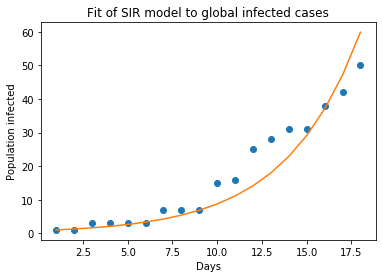

Optimal parameters: beta = 12.108611104419866  and gamma =  11.869996717248677


In [357]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [358]:
lim = len(y)
# mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(y, fitted))
print(rmsle)

0.08211821028622547


# SEIR model

In [42]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, E0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma, sigma = 0.6, 1/10, 0.1

In [43]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [45]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


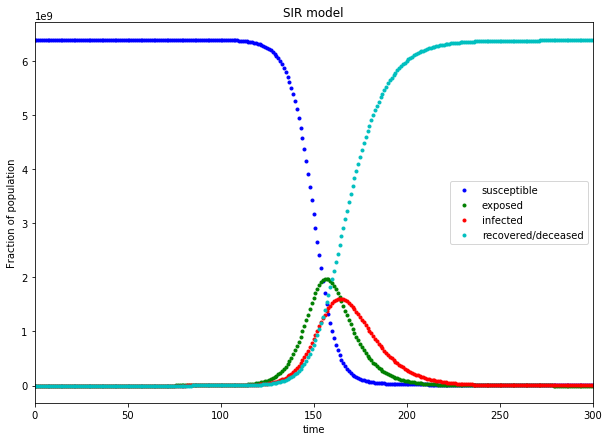

In [50]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(E, 'g.', label='exposed');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [53]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

53

In [54]:
Y = df['Confirmed'].values
X = df['Day num'].values

In [64]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [65]:
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [83]:
def opt_ode(x, beta, gamma, sigma):
    return odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma = params
    ret = odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [84]:
# np.array(x)

In [85]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.1732024348287105
 hess_inv: array([[  83.23560151,   83.2846664 , -163.59288829],
       [  83.2846664 ,   83.33404429, -163.69260408],
       [-163.5928883 , -163.69260409,  321.56810277]])
      jac: array([ 0.36600917, -0.43451215, -0.03518205])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 842
      nit: 71
     njev: 166
   status: 2
  success: False
        x: array([-0.88165173, -0.95865136,  1.54575197])


In [86]:
# pcov

In [87]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


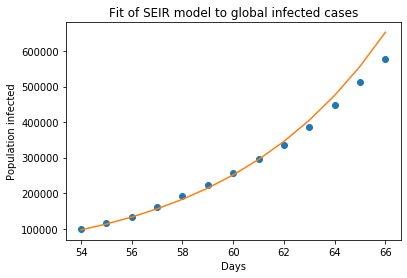

Optimal parameters: beta = 1.8042113573982936 , gamma =  0.7266296019996217 , sigma =  0.16124780607055073


In [88]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [72]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma = beta_hat[0], beta_hat[1], beta_hat[2]

In [73]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [74]:
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, [i for i in range(300)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


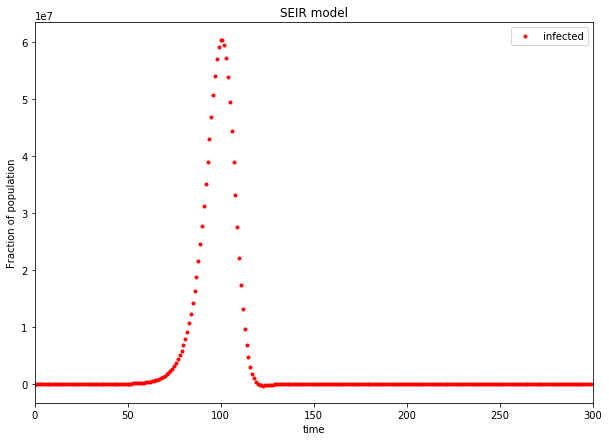

In [78]:
f = plt.figure(figsize=(10,7)) 
# plt.plot(S, 'b.', label='susceptible');
# plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r.', label='infected');
# plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [ ]:
plt.plot(X, Y, 'o')
plt.plot(X, I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [722]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y[index:], I[index:]))
print(rmsle)

0.0027062455057456133


In [653]:
# [1/i for i in x][::-1]

In [654]:
max(I)

665811.4133469954

# Analysing each country individualy

In [191]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [192]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [193]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [194]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [195]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [196]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [361]:
country ='Portugal'

In [362]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0)
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,Country/Region,Lat,Long,Date,Confirmed
7075,Portugal,39.3999,-8.2245,2020-03-02,2
7253,Portugal,39.3999,-8.2245,2020-03-03,2
7431,Portugal,39.3999,-8.2245,2020-03-04,5
7609,Portugal,39.3999,-8.2245,2020-03-05,8
7787,Portugal,39.3999,-8.2245,2020-03-06,13


In [363]:
N = int(pop[pop['Country/Region'] == country]['Population'])
N

10196709

In [364]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,Country/Region,Lat,Long,Date,Confirmed,Day num
11347,Portugal,39.3999,-8.2245,2020-03-26,3544,25
11525,Portugal,39.3999,-8.2245,2020-03-27,4268,26
11703,Portugal,39.3999,-8.2245,2020-03-28,5170,27
11881,Portugal,39.3999,-8.2245,2020-03-29,5962,28
12059,Portugal,39.3999,-8.2245,2020-03-30,6408,29


In [365]:
Y = temp['Confirmed'].values
X = temp['Day num'].values

In [366]:
y = temp['Confirmed'].values
x = temp['Day num'].values

# N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [367]:
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [368]:
def opt_ode(x, beta, gamma, sigma):
    return odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma = params
    ret = odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [369]:
# np.array(x)

In [370]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.09242607687174989
 hess_inv: array([[1.41730872e-01, 1.35618142e-02, 8.79063086e-04],
       [1.35618142e-02, 4.95034459e-03, 2.50110620e-04],
       [8.79063086e-04, 2.50110620e-04, 1.30125395e-05]])
      jac: array([ 0.00379196,  0.08607789, -1.87024583])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 515
      nit: 12
     njev: 101
   status: 2
  success: False
        x: array([ 6.58113505, -0.54481696, -0.01192535])


In [371]:
# pcov

In [372]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


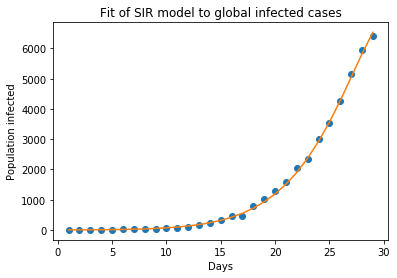

Optimal parameters: beta = 7.588821981409679 , gamma =  7.349716217767908e-16 , sigma =  0.004553724588551945


In [373]:
plt.plot(x, y, 'o')
plt.plot(x, I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [374]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y, I))
print(rmsle)

0.022015070291250195


# SIQR model

In [389]:
# Total population, N without china
N = 6.4 *(10**9)
I0, R0, Q0 = 10, 0, 0
S0 = N - I0 - R0 - Q0
alpha, beta, gamma = 2.0, 1/10, 1.0

In [390]:
# The SIR model differential equations.
def deriv(y, t, N, alpha, beta, gamma):
    S, I, Q, R = y
    dSdt = (-alpha * S * I) / N
    dIdt = (alpha * S * I) / N - (gamma * I) - (beta * I)
    dQdt = (beta * I) - (gamma * Q) 
    dRdt = (gamma * I) + (gamma * Q)
    return dSdt, dIdt, dQdt, dRdt


In [395]:
# Initial conditions vector
y0 = S0, I0, Q0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, [i for i in range(100)], args=(N, alpha, beta, gamma))

S, I, Q, R = ret.T


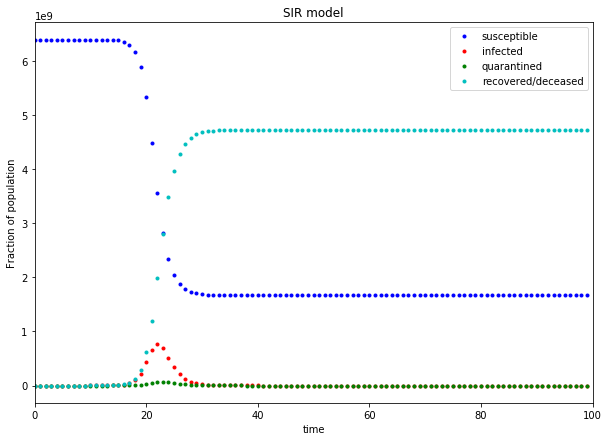

In [396]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(Q, 'g.', label='quarantined');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()